In [1]:
import numpy as np
from multipatch_analysis.database import SynphysDatabase
from multipatch_analysis.cell_class import CellClass, classify_cells, classify_pairs
from multipatch_analysis.connectivity import measure_connectivity

In [2]:
db = SynphysDatabase(ro_host='sqlite:///', rw_host=None, db_name='/home/luke/public/synphys_current_small.sqlite')

Define criteria for all cell classes that we want to compare:

In [30]:
cell_class_criteria = {
    'l23pyr': {'dendrite_type': 'spiny',       'cortical_layer': '2/3', 'display_names': ('L2/3', 'Pyr\nspiny')},
    'l23pv':  {'cre_type': 'pvalb',            'cortical_layer': '2/3', 'display_names': ('L2/3', 'Pv')},
    'l23sst': {'cre_type': 'sst',              'cortical_layer': '2/3', 'display_names': ('L2/3', 'Sst')},
    'l23vip': {'cre_type': 'vip',              'cortical_layer': '2/3', 'display_names': ('L2/3', 'Vip')},
    'l4pyr':  {'cre_type': 'nr5a1',            'cortical_layer': '4',   'display_names': ('L4', 'Pyr\n nr5a1')},
    'l4pv':   {'cre_type': 'pvalb',            'cortical_layer': '4',   'display_names': ('L4', 'Pv')},
    'l4sst':  {'cre_type': 'sst',              'cortical_layer': '4',   'display_names': ('L4', 'Sst')},
    'l4vip':  {'cre_type': 'vip',              'cortical_layer': '4',   'display_names': ('L4', 'Vip')},
    'l5et':   {'cre_type': ('sim1', 'fam84b'), 'cortical_layer': '5',   'display_names': ('L5', 'Pyr ET\nsim1, fam84b')},
    'l5it':   {'cre_type': 'tlx3',             'cortical_layer': '5',   'display_names': ('L5', 'Pyr IT\ntlx3')}, 
    'l5pv':   {'cre_type': 'pvalb',            'cortical_layer': '5',   'display_names': ('L5', 'Pv')},
    'l5sst':  {'cre_type': 'sst',              'cortical_layer': '5',   'display_names': ('L5', 'Sst')},
    'l5vip':  {'cre_type': 'vip',              'cortical_layer': '5',   'display_names': ('L5', 'Vip')},
    'l6pyr':  {'cre_type': 'ntsr1',            'cortical_layer': ('6a','6b'),   'display_names': ('L6', 'Pyr\nntsr1')},
    'l6pv':   {'cre_type': 'pvalb',            'cortical_layer': ('6a','6b'),   'display_names': ('L6', 'Pv')},
    'l6sst':  {'cre_type': 'sst',              'cortical_layer': ('6a','6b'),   'display_names': ('L6', 'Sst')},
    'l6vip':  {'cre_type': 'vip',              'cortical_layer': ('6a','6b'),   'display_names': ('L6', 'Vip')},
}

Create a `CellClass` object to represent each cell class described above:

In [31]:
cell_classes = {name:CellClass(**criteria) for name,criteria in cell_class_criteria.items()}

Get a list of all cell pairs in the database from mouse matrix projects:

In [32]:
pairs = db.pair_query(project_name=["mouse V1 coarse matrix", "mouse V1 pre-production"]).all()
len(pairs)

77084

Group our selected pairs by pre- and postsynaptic cell type, then measure the probability of connectivity for each group

In [33]:
# Group all cells by selected classes
cell_groups = classify_cells(cell_classes.values(), pairs=pairs)

# Group pairs into (pre_class, post_class) groups
pair_groups = classify_pairs(pairs, cell_groups)

# analyze matrix elements
results = measure_connectivity(pair_groups)

At this point we have all data loaded and connection probabilities have been computed. For each combination of (presynaptic_class, postsynaptic_class), we have a result dictionary that includes the number of putative connections probed, the number of synapses found, and the connection probability with 95% confidence intervals:

In [34]:
# pick two arbitrary cell classes to display results from
pre_class = cell_classes['l23sst']
post_class = cell_classes['l23vip']
print("Connectivity results for %s => %s" % (pre_class, post_class))
results[pre_class, post_class]

Connectivity results for L2/3 Sst => L2/3 Vip


{'n_probed': 27,
 'n_connected': 4,
 'connection_probability': (0.14814814814814814,
  0.04188739647376729,
  0.3373108640242445),
 'connected_pairs': [<pair 1520895746.584 2 1>,
  <pair 1534976379.977 6 3>,
  <pair 1540849442.801 7 1>,
  <pair 1553896481.301 3 8>],
 'probed_pairs': [<pair 1520895746.584 2 1>,
  <pair 1529355466.393 1 7>,
  <pair 1530822740.956 2 6>,
  <pair 1533590781.564 3 1>,
  <pair 1533590781.564 4 1>,
  <pair 1533590300.172 4 2>,
  <pair 1533590300.172 4 6>,
  <pair 1534367207.869 4 2>,
  <pair 1534976379.977 1 3>,
  <pair 1534976379.977 6 3>,
  <pair 1538508672.857 8 1>,
  <pair 1540844366.306 1 7>,
  <pair 1540844366.306 1 8>,
  <pair 1540849442.801 7 1>,
  <pair 1540849442.801 7 2>,
  <pair 1540849442.801 8 1>,
  <pair 1540849442.801 8 2>,
  <pair 1541027210.273 1 6>,
  <pair 1541105675.698 2 1>,
  <pair 1541105675.698 7 1>,
  <pair 1550276418.296 8 7>,
  <pair 1553122750.482 2 3>,
  <pair 1553896481.301 3 1>,
  <pair 1553896481.301 3 8>,
  <pair 1554755655.95

The results computed above must now be transformed into 2D arrays of colors and labels before being displayed as a heat map

In [35]:
import matplotlib.colors, matplotlib.cm

# convert dictionary of results to a 2d array of connection probabilities
cprob = np.zeros((len(cell_classes),)*2)
cprob_alpha = cprob.copy()
cprob_str = np.zeros((len(cell_classes),)*2, dtype=object)

for i,pre_class in enumerate(cell_classes.values()):
    for j,post_class in enumerate(cell_classes.values()):
        result = results[pre_class, post_class]
        cp, cp_lower_ci, cp_upper_ci = result['connection_probability']
        cprob[i,j] = cp
        cprob_str[i,j] = "" if result['n_probed'] == 0 else "%d/%d" % (result['n_connected'], result['n_probed'])
        cprob_alpha[i,j] = 1.0 - 2.0 * (cp_upper_ci - cp_lower_ci)

# convert classes to a list of strings
class_names = [str(cls) for cls in cell_classes.values()]

# map connection probability to RGB colors
norm = matplotlib.colors.LogNorm(vmin=0.01, vmax=1.0, clip=True)
cmap = matplotlib.cm.get_cmap('plasma')
mapper = matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap)
cprob_rgba = mapper.to_rgba(np.clip(cprob, 0.01, 1.0))

# apply alpha based on confidence intervals
cprob_rgba[:, :, 3] = np.clip(cprob_alpha, 0, 1)

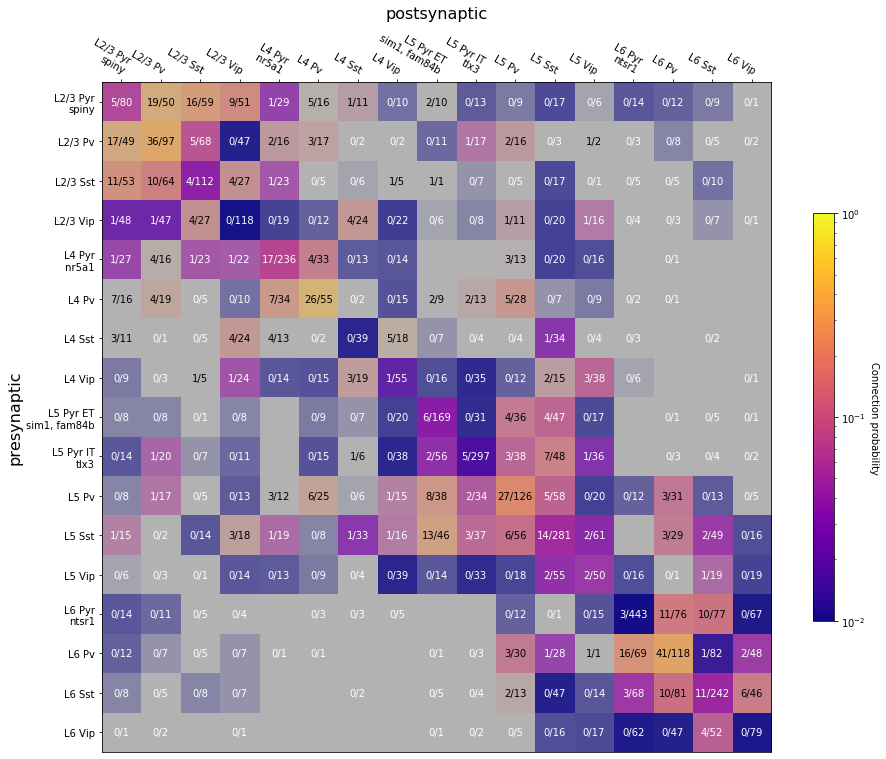

In [36]:
import matplotlib.pyplot as plt
from multipatch_analysis.ui.notebook import heatmap, annotate_heatmap
%matplotlib inline

fig, ax = plt.subplots(figsize=(15, 15))

im, cbar = heatmap(cprob_rgba, class_names, class_names, ax=ax, 
    ax_labels=('postsynaptic', 'presynaptic'),
    bg_color=(0.7, 0.7, 0.7),
    cmap=cmap, norm=norm, 
    cbarlabel="Connection probability", 
    cbar_kw={'shrink':0.5})

labels = annotate_heatmap(im, cprob_str, data=cprob)

In [37]:
fig.savefig('mouse_connectivity_matrix.svg', format='svg')